# Cavern storage capacity

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import capacity as cap
from h2ss import data as rd
from h2ss import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

In [5]:
# exploration wells
_, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# wind farms
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

# frequent shipping routes
_, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# shipwrecks
_, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# subsea cables
_, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [6]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

In [7]:
caverns, _ = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 4,084
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 1,776
Caverns excluded: 56.51%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 1,416
Caverns excluded: 65.33%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 1,348
Caverns excluded: 66.99%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 1,348
Caverns excluded: 66.99%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 1,348
Caverns excluded: 66.99%
------------------------------------------------------------


In [8]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[85, 155, 311],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

## Capacity

### Volume

In [9]:
caverns["cavern_volume"] = cap.cavern_volume(height=caverns["cavern_height"])
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_volume"]
)

### Mid-point temperature

In [10]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

### Operating pressure

In [11]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepthSeabed"])

### Hydrogen gas density

In [12]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

### Working mass of hydrogen

In [13]:
(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

### Energy storage capacity in GWh

In [14]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Stats

In [15]:
caverns.drop(
    ["x", "y", "TopTWT", "BaseDepth", "TopDepth", "BaseDepthSeabed"], axis=1
).describe()

,Thickness,TopDepthSeabed,cavern_height,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity
count,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000,1.348000e+03,1.348000e+03,1348.000000,1348.000000,1.348000e+03,1.348000e+03,1.348000e+03,1348.000000
mean,276.521542,1094.339404,137.899110,1174.339404,285279.527390,329.773336,8.053268e+06,2.147538e+07,5.577565,13.790147,2.363801e+06,1.606842e+06,3.970643e+06,78.767098
std,79.516373,380.577830,61.090549,380.577830,147086.425811,14.406024,2.688097e+06,7.168260e+06,1.561989,3.601784,1.435664e+06,1.004796e+06,2.439740e+06,47.839519
min,175.012400,420.214316,85.000000,500.214316,157915.456354,303.753157,3.291788e+06,8.778101e+06,2.569076,6.638388,6.533564e+05,4.128394e+05,1.066196e+06,21.771288
25%,214.203125,766.233205,85.000000,846.233205,157915.456354,317.104602,5.735788e+06,1.529544e+07,4.250520,10.749535,1.411112e+06,9.322243e+05,2.332329e+06,47.021394
50%,259.453000,1074.276101,155.000000,1154.276101,326452.980096,329.571549,7.911557e+06,2.109749e+07,5.577949,13.865333,1.907525e+06,1.293581e+06,3.180532e+06,63.562983
75%,327.029325,1375.896933,155.000000,1455.896933,326452.980096,339.930537,1.004197e+07,2.677857e+07,6.786070,16.607578,3.009535e+06,2.055877e+06,5.064592e+06,100.284392
max,713.672500,1919.031682,311.000000,1999.031682,702050.890150,361.506811,1.387823e+07,3.700863e+07,8.689494,20.759546,8.249865e+06,5.904503e+06,1.415437e+07,274.903831


In [16]:
# cavern volumes
list(caverns["cavern_volume"].unique())

[326452.98009604175, 157915.45635408553, 702050.8901495441]

In [17]:
# total capacity
caverns[["capacity"]].sum().iloc[0]

106178.04805838442

In [18]:
# total capacity at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

,,capacity,%
height,depth,,
155,"1,000 - 1,500",29735.074636,28.004917
85,"1,000 - 1,500",11221.134104,10.568224
311,"1,000 - 1,500",13317.018329,12.542158
155,"1,500 - 2,000",14227.205282,13.399385
85,"1,500 - 2,000",5049.292612,4.755496
311,"1,500 - 2,000",6286.645419,5.920852
85,"500 - 1,000",8108.391096,7.636598
155,"500 - 1,000",15837.754659,14.916223
311,"500 - 1,000",2395.531921,2.256146


In [19]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",54273.227069
"1,500 - 2,000",25563.143314
"500 - 1,000",26341.677676


In [20]:
s.groupby("height").sum()[["capacity"]]

,capacity
height,
155,59800.034577
311,21999.195669
85,24378.817812


In [21]:
# number of caverns
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].count()
s["%"] = s["capacity"] / len(caverns) * 100
s

,,capacity,%
height,depth,,
155,"1,000 - 1,500",309,22.922849
85,"1,000 - 1,500",233,17.284866
311,"1,000 - 1,500",65,4.821958
155,"1,500 - 2,000",116,8.605341
85,"1,500 - 2,000",86,6.379822
311,"1,500 - 2,000",25,1.854599
85,"500 - 1,000",251,18.620178
155,"500 - 1,000",245,18.175074
311,"500 - 1,000",18,1.335312


In [22]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",607
"1,500 - 2,000",227
"500 - 1,000",514


In [23]:
s.groupby("height").sum()[["capacity"]]

,capacity
height,
155,670
311,108
85,570


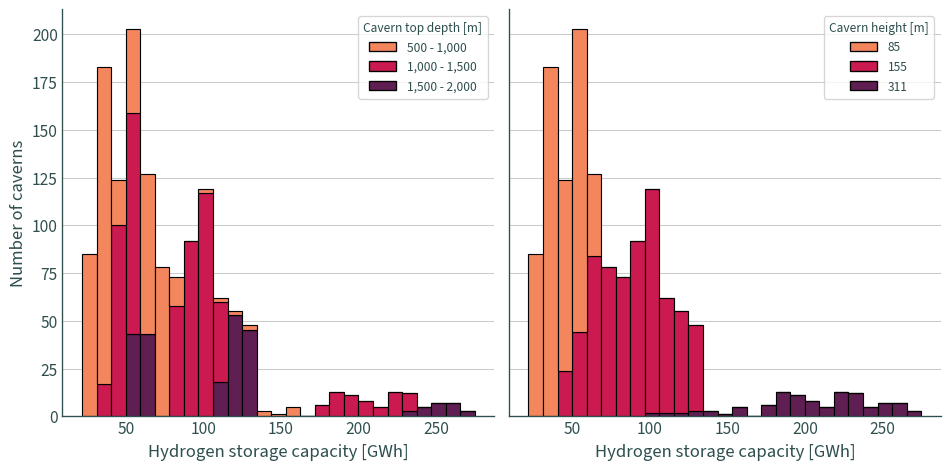

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.histplot(
    caverns.rename(columns={"depth": "Cavern top depth [m]"}).sort_values(
        "TopDepthSeabed"
    ),
    x="capacity",
    hue="Cavern top depth [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
    ax=axes[0],
)
sns.histplot(
    caverns.rename(columns={"height": "Cavern height [m]"}).sort_values(
        "Thickness"
    ),
    x="capacity",
    hue="Cavern height [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
    ax=axes[1],
)
axes[0].set_xlabel("Hydrogen storage capacity [GWh]")
axes[1].set_xlabel("Hydrogen storage capacity [GWh]")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
axes[0].set_ylabel("Number of caverns")
sns.despine()
plt.tight_layout()
plt.show()

## Maps

In [25]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [26]:
def plot_map_alt(
    dat_xr, cavern_df, zones_gdf, classes, top_depth=True, fontsize=11.5
):
    """Helper function to plot caverns within the zones of interest"""
    plt.figure(figsize=(20, 11.5))
    axis = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles = []

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Area of interest",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    legend_handles.append(
        mpatches.Patch(
            label="Hydrogen storage \ncapacity [GWh]", visible=False
        )
    )

    colours = [int(n * 255 / (len(classes) - 1)) for n in range(len(classes))]
    for n, y in enumerate(colours):
        if n == 0:
            c = cavern_df[cavern_df["capacity"] < classes[1]]
            label = f"< {classes[1]}"
        elif n == len(classes) - 1:
            c = cavern_df[cavern_df["capacity"] >= classes[n]]
            label = f"≥ {classes[n]}"
        else:
            c = cavern_df[
                (cavern_df["capacity"] >= classes[n])
                & (cavern_df["capacity"] < classes[n + 1])
            ]
            label = f"{classes[n]} - {classes[n + 1]}"
        for df, markersize in zip(
            [
                c[c["depth"] == "500 - 1,000"],
                c[c["depth"] == "1,000 - 1,500"],
                c[c["depth"] == "1,500 - 2,000"],
            ],
            [20, 50, 20],
        ):
            if len(df) > 0:
                df.centroid.plot(
                    ax=axis,
                    zorder=3,
                    linewidth=0,
                    marker=".",
                    markersize=markersize,
                    color=sns.color_palette("flare", 256)[y],
                )
        legend_handles.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[y], label=label
            )
        )

    if top_depth:
        legend_handles.append(
            mpatches.Patch(label="Cavern top depth [m]", visible=False)
        )
        for markersize, label in zip(
            [6, 3], ["1,000 - 1,500", "500 - 1,000 or \n1,500 - 2,000"]
        ):
            legend_handles.append(
                Line2D(
                    [0],
                    [0],
                    marker=".",
                    linewidth=0,
                    label=label,
                    color="darkslategrey",
                    markersize=markersize,
                )
            )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis, crs=rd.CRS, source=cx.providers.CartoDB.VoyagerNoLabels, zoom=12
    )
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
        xlabel_style={"fontsize": fontsize},
        ylabel_style={"fontsize": fontsize},
    )
    axis.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            width_fraction=0.0075,
            font_properties={"size": fontsize},
        )
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles,
        fontsize=fontsize,
    )

    plt.tight_layout()
    plt.show()

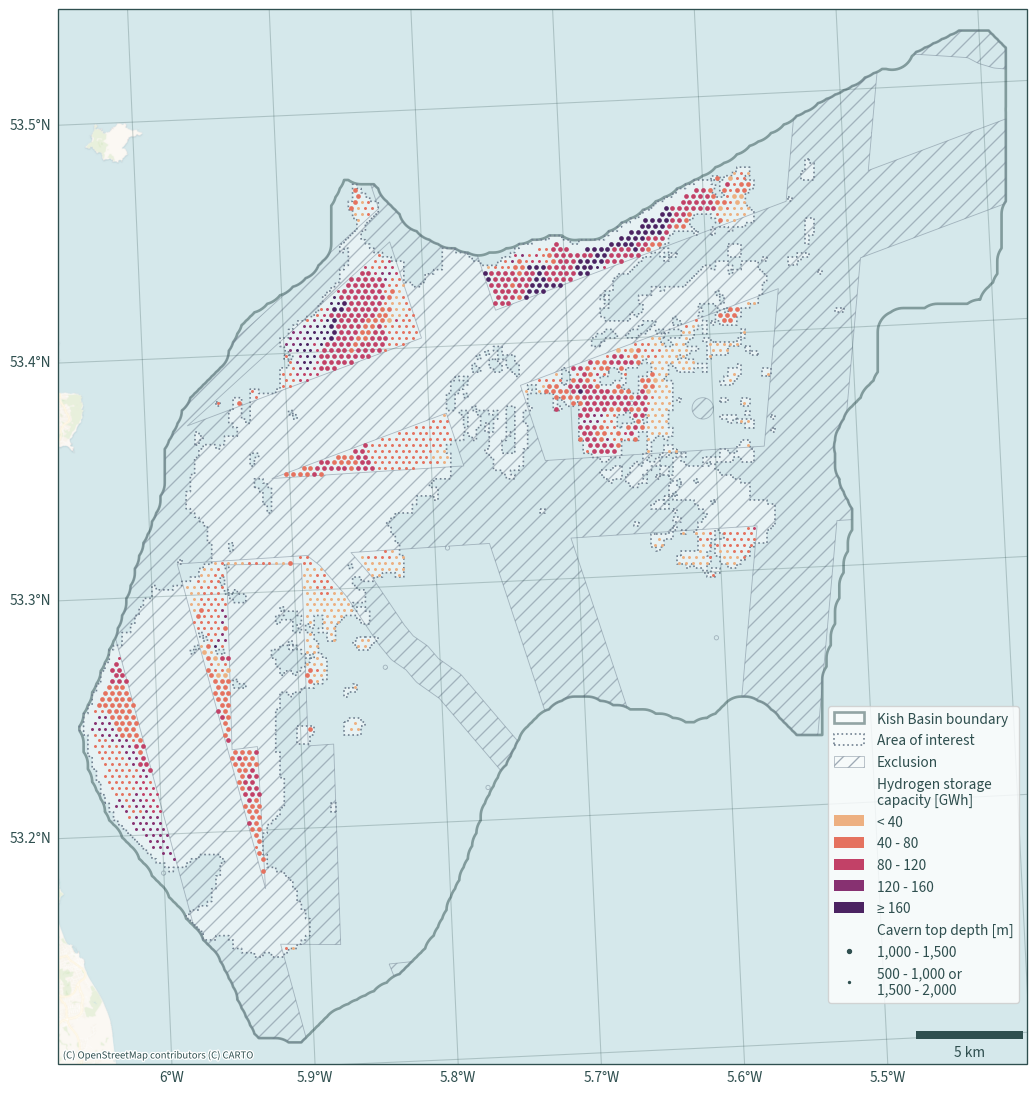

In [27]:
plot_map_alt(ds, caverns, zones, [40 * n for n in range(5)])

## Restrict cavern height to 155 m, depth to 1,000-1,500 m

In [28]:
# height = 155 m, 1,000 m <= depth <= 1,500 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds,
    constraints={"height": 155, "min_depth": 1000, "max_depth": 1500},
)

In [29]:
caverns, _ = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 901
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 406
Caverns excluded: 54.94%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 359
Caverns excluded: 60.16%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 357
Caverns excluded: 60.38%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 357
Caverns excluded: 60.38%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 357
Caverns excluded: 60.38%
------------------------------------------------------------


In [30]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[155],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [31]:
# calculate volumes and capacities
caverns = cap.calculate_capacity_dataframe(cavern_df=caverns)

In [32]:
caverns.drop(
    [
        "x",
        "y",
        "TopTWT",
        "BaseDepth",
        "TopDepth",
        "BaseDepthSeabed",
        "height",
        "cavern_height",
    ],
    axis=1,
).describe()

,Thickness,TopDepthSeabed,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity
count,357.000000,357.000000,357.000000,357.000000,357.000000,3.570000e+02,3.570000e+02,357.000000,357.000000,3.570000e+02,3.570000e+02,3.570000e+02,357.000000
mean,338.740399,1170.063748,1250.063748,326452.980096,332.933641,8.588124e+06,2.290166e+07,5.958305,14.728154,2.862943e+06,1.945107e+06,4.808050e+06,95.399630
std,77.837415,142.462283,142.462283,0.000000,5.342336,1.006240e+06,2.683306e+06,0.574618,1.311962,2.407155e+05,1.875857e+05,4.282938e+05,8.021174
min,245.000700,921.433357,1001.433357,326452.980096,323.610001,6.831998e+06,1.821866e+07,4.928948,12.355579,2.424446e+06,1.609070e+06,4.033516e+06,80.787928
25%,279.352100,1038.819500,1118.819500,326452.980096,328.011981,7.661120e+06,2.042965e+07,5.430381,13.524349,2.642300e+06,1.772764e+06,4.415064e+06,88.047298
50%,325.618300,1168.179123,1248.179123,326452.980096,332.862967,8.574813e+06,2.286617e+07,5.962795,14.748328,2.868063e+06,1.946572e+06,4.814635e+06,95.570243
75%,376.148200,1288.417123,1368.417123,326452.980096,337.371892,9.424078e+06,2.513087e+07,6.439678,15.830123,3.065539e+06,2.102252e+06,5.167791e+06,102.150568
max,713.672500,1419.814781,1499.814781,326452.980096,342.299304,1.035217e+07,2.760578e+07,6.942048,16.955276,3.268848e+06,2.266252e+06,5.535100e+06,108.925282


In [33]:
# cavern volumes
list(caverns["cavern_volume"].unique())

[326452.98009604175]

In [34]:
# total volume
caverns[["cavern_volume"]].sum().iloc[0]

116543713.8942869

In [35]:
# total capacity
caverns[["capacity"]].sum().iloc[0]

34057.667815877205

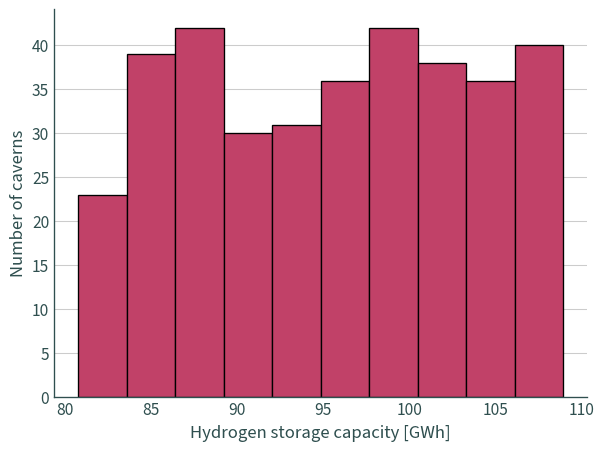

In [36]:
ax = sns.histplot(
    caverns, x="capacity", alpha=1, color=sns.color_palette("flare", 5)[2]
)
ax.set_xlabel("Hydrogen storage capacity [GWh]")
ax.grid(which="major", axis="y")
ax.set_ylabel("Number of caverns")
sns.despine()
plt.tight_layout()
plt.show()

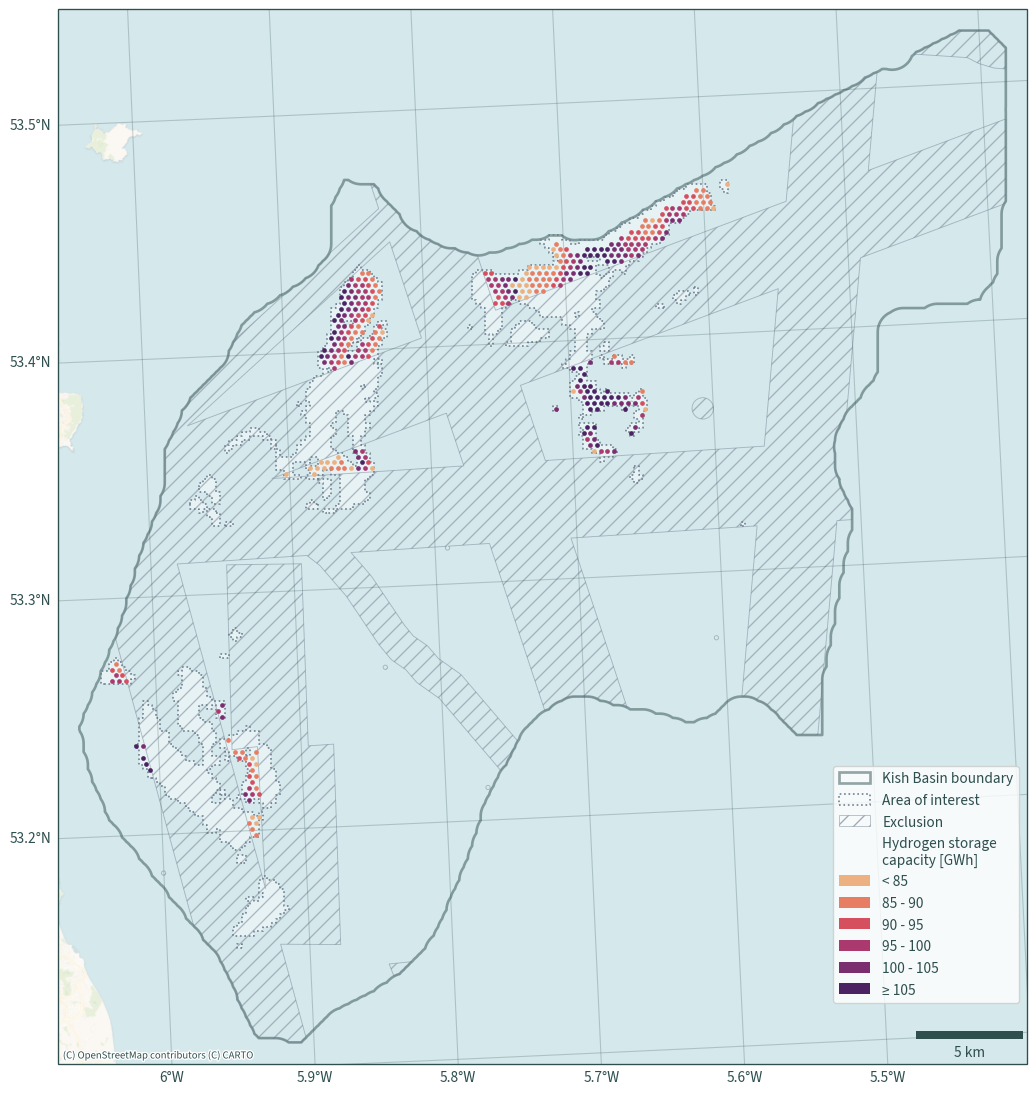

In [40]:
plot_map_alt(ds, caverns, zones, [80 + n * 5 for n in range(6)], False)